# Denoising Autoencoder (DAE)

This project demonstrates the implementation of a Denoising Autoencoder (DAE) using PyTorch. The DAE is trained to remove noise from images, specifically using the CIFAR-10 dataset.

## Algorithm Explanation

A Denoising Autoencoder is a type of neural network used to learn efficient codings of input data while removing noise. The network consists of two main parts:

1. **Encoder**: This part compresses the input image into a lower-dimensional representation.
2. **Decoder**: This part reconstructs the image from the compressed representation.

The network is trained to minimize the difference between the original and reconstructed images, effectively learning to remove noise from the input images.

## Import libaries

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset

from tqdm import trange

set device

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
device

device(type='cuda')

### transform function to transform images to Tensors

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

## Loading the dataset (CIFAR10)

In [ ]:
train_dataset = datasets.CIFAR10(
    root='../../../datasets',
    download=False, # True if not downloaded
    train=True,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root='../../../datasets',
    download=False, # True if not downloaded
    train=False,
    transform=transform
)

# `add_noise`: Salt Noise Generator for Torch Tensors

This function simulates **salt noise** by randomly selecting a fraction of an image’s pixels and decreasing their values. It is useful for training **denoising autoencoders**, robustness testing, or exploring data augmentation techniques.

## Parameters

- **`image (torch.Tensor)`**: A 3D or 4D image tensor of shape `(C, H, W)` or `(1, C, H, W)`.
- **`noise_level (float)`**: Fraction of pixels to be noised, e.g., `0.01` means 1% of pixels.

## Operation Summary

- If needed, reshapes the image to include a batch dimension.
- Randomly selects a subset of pixels based on `noise_level`.
- Subtracts `1` from the selected pixels (simulating dark "salt" noise).
- Ensures pixel values remain within the valid range `[0, 1]`.

## Use Cases

- Training and evaluating **denoising autoencoders**.
- Simulating **image corruption** for robustness testing.
- Simple augmentation in self-supervised learning settings.

In [ ]:
def add_noise(image: torch.Tensor, noise_level=0.01):
    # Ensure the input has a batch dimension: (1, C, H, W)
    if len(image.shape) == 3:
        image = image.unsqueeze(dim=0)

    # Create a copy of the image tensor to preserve the original
    noisy_image = image.clone()

    # Get dimensions: batch size (_), channels, height, width
    _, c, h, w = image.shape
    total_pixels = c * h * w  # Total number of pixels across all channels
    total_noisy_pixels = int(noise_level * total_pixels)  # Number of pixels to corrupt

    # Randomly select flat pixel indices to corrupt
    noisy_pixel_indices = torch.randint(0, total_pixels, (total_noisy_pixels,))

    # Map flat indices to 3D (channel, height, width) coordinates
    noisy_pixels_c = noisy_pixel_indices // (h * w)
    noisy_pixels_h = (noisy_pixel_indices % (h * w)) // w
    noisy_pixels_w = noisy_pixel_indices % w

    # Subtract 1 from the selected pixels to simulate "pepper" noise (darkening)
    # Clamp ensures pixel values remain within [0, 1]
    noisy_image[:, noisy_pixels_c, noisy_pixels_h, noisy_pixels_w] = torch.clamp(
        noisy_image[:, noisy_pixels_c, noisy_pixels_h, noisy_pixels_w] - 1, min=0, max=1
    )

    return noisy_image

### display single image

A function to display an image and noise added to it

In [7]:
def display_single_image(image: torch.Tensor, noise_level=0.01):
    fig, axes = plt.subplots(1, 2, figsize=(3, 3))
    
    axes = axes.flatten()

    image_noisy = add_noise(image, noise_level)

    axes[0].imshow(image_noisy.squeeze().permute(1, 2, 0))
    axes[1].imshow(image.squeeze().permute(1, 2, 0))
    axes[0].axis('off')
    axes[1].axis('off')
    plt.show()

Move dataset to pytorch DataLoaders

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=True)

### Below is an image with noise added to it

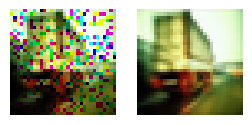

In [9]:
random_idx = torch.randint(low=0, high=len(train_dataset), size=(1,)).item()

display_single_image(train_dataset[random_idx][0], noise_level=0.2)

## Convolutional Autoencoder

In this notebook we will use convolutional autoencoders which is better for image type dataset.

## 2D Convolution and Transposed Convolution: Mathematical Explanation

### Introduction

In deep learning, **convolutional layers** are the backbone of convolutional neural networks (CNNs). Convolution operations apply a filter (or kernel) to input data (such as images) to extract features. **Transposed convolution** is used in tasks like **upsampling** or **generating larger feature maps**.

---

## 1. **2D Convolution**

### Definition

The **2D convolution** operation is the process of applying a kernel/filter to an input image or feature map. It slides the kernel over the image to compute the output feature map. The output size depends on the kernel size, stride, and padding.

Let:
- Input image: $I \in \mathbb{R}^{H \times W}$
- Filter (kernel): $K \in \mathbb{R}^{k_H \times k_W}$
- Output feature map: $O \in \mathbb{R}^{H' \times W'}$

### Mathematical Formula

The 2D convolution operation computes the output at each position by performing an element-wise multiplication between the kernel and the local receptive field in the input image, followed by a summation:

$$
O(i, j) = \sum_{m=0}^{k_H-1} \sum_{n=0}^{k_W-1} I(i+m, j+n) \cdot K(m, n)
$$

Where:
- $i, j$ are the indices of the output feature map.
- $m, n$ are the indices of the kernel.
- $k_H$ and $k_W$ are the height and width of the kernel.

### Parameters:
- **Stride**: The step size at which the filter moves across the input. A stride of 1 means the filter moves one pixel at a time.
- **Padding**: The process of adding extra pixels around the border of the input image. It allows the kernel to fully slide over the borders.

The output size with stride $S$ and padding $P$ is given by:

$$
H' = \frac{H + 2P - k_H}{S} + 1
$$
$$
W' = \frac{W + 2P - k_W}{S} + 1
$$

---

## 2. **2D Transposed Convolution**

### Definition

**Transposed convolution** (also called **fractionally strided convolution** or **deconvolution**) is the reverse process of 2D convolution. It is used for **upsampling**, where the goal is to produce a larger output from a smaller input by reversing the operation of convolution.

Let:
- Input feature map: $I \in \mathbb{R}^{H' \times W'}$
- Filter (kernel): $K \in \mathbb{R}^{k_H \times k_W}$
- Output image: $O \in \mathbb{R}^{H \times W}$

### Mathematical Formula

In transposed convolution, the kernel is applied in reverse (flipped both horizontally and vertically), and the values are inserted into the output at the corresponding positions:

$$
O(i, j) = \sum_{m=0}^{k_H-1} \sum_{n=0}^{k_W-1} I(i-m, j-n) \cdot K(m, n)
$$

Where:
- $i, j$ are the indices of the output feature map.
- $m, n$ are the indices of the kernel.
- $k_H$ and $k_W$ are the height and width of the kernel.

Transposed convolution can also introduce a **stride** and **padding**. The output size with stride $S$ and padding $P$ is given by:

$$
H = (H' - 1) \cdot S + k_H - 2P
$$
$$
W = (W' - 1) \cdot S + k_W - 2P
$$

### Visualizing the Difference

While **2D convolution** reduces the spatial dimensions of the input image, **transposed convolution** increases the spatial dimensions (height and width). In transposed convolution, the filter is applied in reverse, and the result is "spread out" into the larger output size.

---

## Applications

1. **2D Convolution**:
   - Feature extraction in CNNs.
   - Edge detection, pattern recognition in images.
   - Used in layers like `nn.Conv2d` in PyTorch.

2. **2D Transposed Convolution**:
   - Upsampling in generative networks (e.g., autoencoders, GANs).
   - Image generation and segmentation tasks.
   - Used in layers like `nn.ConvTranspose2d` in PyTorch.

---

## Below is a simple Denoising AutoEncoder architecture

In [10]:
class DAE(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1),
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.decoder(self.encoder(x))
        return self.sigmoid(out)

Train and Test functions for one epoch

In [ ]:
def train_epoch(model: DAE, dataloader: DataLoader, loss_fn: nn.MSELoss, optimizer: torch.optim.Adam, noise_level):
    size = len(dataloader.dataset)
    total_loss = 0
    model.train()

    for batch, (image, _) in enumerate(dataloader):
        image: torch.Tensor

        image = image.to(device) # Move tensors to device
        noisy_image = add_noise(image, noise_level).to(device) # Add noise to image

        logits: torch.Tensor = model(noisy_image) # Reconstruct the image

        loss: torch.Tensor = loss_fn(logits, image) # Calculate loss
        total_loss += loss.item()

        loss.backward() # back propagate
        optimizer.step() # update weights
        optimizer.zero_grad()

    avg_loss = total_loss / size
    return avg_loss


def test_epoch(model: DAE, dataloader: DataLoader, loss_fn: nn.MSELoss, noise_level):
    model.eval()
    size = len(dataloader.dataset)
    total_loss = 0

    with torch.no_grad():
        for image, _ in dataloader:
            image: torch.Tensor

            image = image.to(device)

            noisy_image = add_noise(image, noise_level)

            logits: torch.Tensor = model(noisy_image)

            loss: torch.TensorBase = loss_fn(logits, image)
            total_loss += loss.item()

    avg_loss = total_loss / size
    return avg_loss

### General train function to train the model

In [ ]:
def train(model: DAE, train_loader: DataLoader, test_loader: DataLoader, n_epochs=10, lr=0.01, noise_level=0.01):

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    saves = {'train_loss': [], 'test_loss': []}

    for epoch in (pbar := trange(n_epochs)):
        train_loss = train_epoch(model, train_loader, loss_fn, optimizer, noise_level=noise_level)
        test_loss = test_epoch(model, test_loader, loss_fn, noise_level=noise_level)

        pbar.set_description(f'Epoch {epoch + 1} | train loss {train_loss} | test loss {test_loss}')

        saves['train_loss'].append(train_loss)
        saves['test_loss'].append(test_loss)
    return saves

### Train for 60 epochs

In [ ]:
model = DAE().to(device)
saves = train(model, train_dataloader, test_dataloader, n_epochs=60, lr=0.01, noise_level=0.1)

Epoch 60 | train loss 4.642595374025405e-06 | test loss 4.189865686930716e-06: 100%|██████████| 60/60 [11:38<00:00, 11.65s/it]  


### Display results for 60 epochs

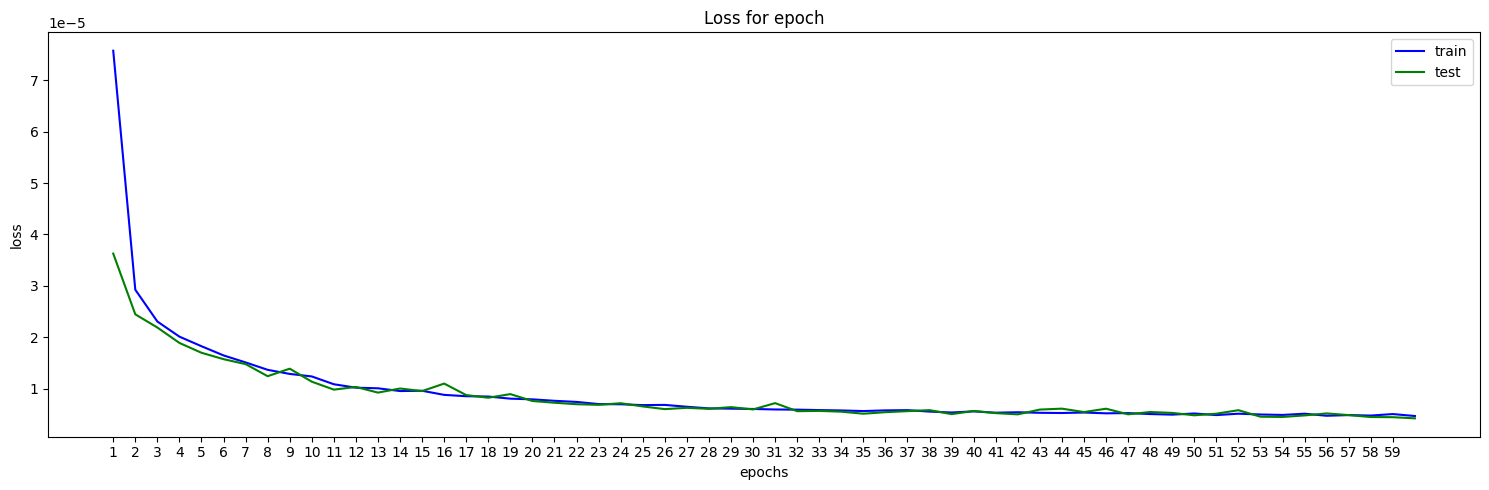

In [ ]:
n_epochs = np.arange(len(saves['train_loss'])).astype(int) + 1

train_loss = saves['train_loss']
test_loss = saves['test_loss']

plt.figure(figsize=(15, 5))
plt.plot(n_epochs, train_loss, c='blue', label='train')
plt.plot(n_epochs, test_loss, c='green', label='test')
plt.title('Loss for epoch')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.xticks(range(1, len(saves['train_loss'])))
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
def display_image_noise_recon(model: DAE, image: torch.Tensor, noise_level=0.01):
    fig, axes = plt.subplots(1, 3, figsize=(3, 3))

    noisy_image: torch.Tensor = add_noise(image, noise_level=noise_level)
    recon: torch.Tensor = model(noisy_image.to(device))

    axes[0].imshow(image.permute(1, 2, 0))
    axes[1].imshow(noisy_image.squeeze().permute(1, 2, 0))
    axes[2].imshow(recon.squeeze().permute(1, 2, 0).cpu().detach().numpy())
    for i in range(3):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [17]:
def show_model(model: DAE, dataset: datasets.CIFAR10, noise_level=0.01):
    random_idx = torch.randint(low=0, high=len(dataset), size=(1,))

    image, _ = dataset[random_idx]

    display_image_noise_recon(model, image, noise_level)

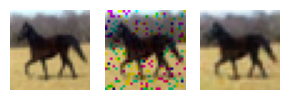

In [18]:
show_model(model, test_dataset, noise_level=0.1)

### From left to right

the first image is actual training image

the second one is noisy image

and the third is reconstructed image by the model